### Plot % of Lab Sea area covered by ice 

In [18]:
# mom6_tools
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import myStats, annotateStats

import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import xarray as xr
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import warnings, os, yaml, glob
warnings.filterwarnings("ignore")

In [19]:
diag_config_yml = yaml.load(open('diag_config_comparison.yml','r'),
                            Loader=yaml.Loader)

In [20]:
# initialize lists
dcase = []; casename=[]
label = []; outdir=[]
ncfiles=[]
ncases = len(diag_config_yml.keys()) - 1
if ncases < 2:
  # Create the case instance
  dcase = DiagsCase(diag_config_yml['Case'], xrformat=True)
  casename.append(dcase.casename)
  label.append(diag_config_yml['Case']['SNAME'])
  ncfiles.append(diag_config_yml['Case']['OCN_DIAG_ROOT'])
  DOUT_S = dcase.get_value('DOUT_S')
  if DOUT_S:
    outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
  else:
    outdir.append(dcase.get_value('RUNDIR'))
else:
  for i in range(ncases):
    cname = 'Case{}'.format(i+1)
    dcase = DiagsCase(diag_config_yml[cname], xrformat=True)
    casename.append(dcase.casename)
    label.append(diag_config_yml[cname]['SNAME'])
    ncfiles.append(diag_config_yml[cname]['OCN_DIAG_ROOT'])
    DOUT_S = dcase.get_value('DOUT_S')
    if DOUT_S:
      outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
    else:
      outdir.append(dcase.get_value('RUNDIR'))
    
# set avg dates
avg = diag_config_yml['Avg']
start_date = avg['start_date']
end_date = avg['end_date']

In [21]:
# for plotting, the following was a feedback from Keith Lindsay.
linestyle = ['solid','solid','solid',
             'dashed','dashed','dashed',
             'dotted','dotted','dotted']
color = ['black','tab:red','tab:blue','black',
         'tab:red','tab:blue','black',
         'tab:red','tab:blue']

In [22]:
ncfiles

['/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026a/ncfiles/',
 '/glade/u/home/gmarques/Notebooks/CESM_MOM6/B/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026b/ncfiles/']

In [23]:
# load grid and pre-difined masks
grd = MOM6grid(outdir[0]+'/'+casename[0]+'.mom6.static.nc');
grd_xr = MOM6grid(outdir[0]+'/'+casename[0]+'.mom6.static.nc', xrformat=True);
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True);

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


In [24]:
lab_sea_mask = (basin_code.sel(region='LabSea').values* 1)

In [25]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

cluster = NCARCluster()
cluster.scale(10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/46866/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/46866/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:40033,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/46866/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [26]:
lab_sea_mask = (basin_code.sel(region='LabSea').values* 1)
masked = np.ma.masked_where(lab_sea_mask==0, lab_sea_mask)
area_lab_sea = basin_code.sel(region='LabSea')*grd_xr.area_t

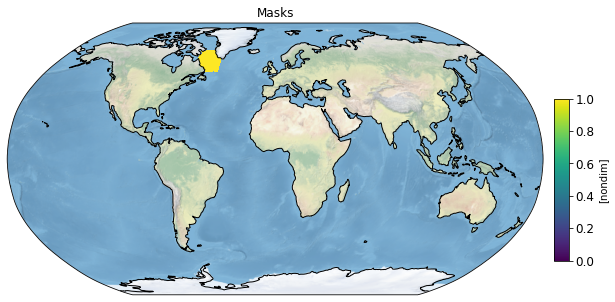

In [27]:
%matplotlib inline

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

pc = ax.pcolormesh(grd.geolon, grd.geolat, masked,
              transform=ccrs.PlateCarree(),vmin=0, vmax=1)

ax.set_title('Masks')
cax = fig.add_axes([0.9, 0.22, 0.02, 0.45])
cbar = plt.colorbar(pc, cax=cax, label='[nondim]')
cbar.ax.tick_params(labelsize=12) 
ax.set_global()
ax.stock_img()
ax.coastlines();

In [28]:
def preprocess(ds):
    variables = ['aice']
    return ds[variables]

In [29]:
basin_code_cice = basin_code.rename({"yh":"nj", "xh":"ni"})

In [30]:
area_lab_sea = area_lab_sea.rename({"yh":"nj", "xh":"ni"})

In [31]:
# load hm files 
var_list = []
for n in range(len(casename)):
  print(casename[n])
  files = sorted(glob.glob(outdir[n]+'../../ice/hist/'+casename[n]+'.cice.h.*.nc'))
  ds = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
  
  ds1 = ds.sel(time=slice('0001-01-01',end_date))
  var = (ds1.aice*basin_code_cice.sel(region='LabSea')\
               *area_lab_sea).sum(dim=['ni','nj'])/\
               (area_lab_sea.sum())

  var_list.append(var)

b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026a
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026b


b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026a
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026b


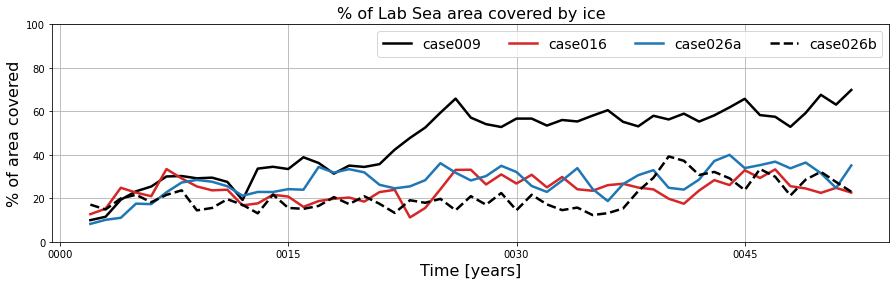

In [32]:
# load hm files 
fig = plt.figure(figsize=(15, 4))

for n in range(len(var_list)):
  print(casename[n])
  
  var = var_list[n].resample(time="1Y", closed='left').mean('time')
  m = len(var)
  plt.plot(var.time[0:m-1], var[0:m-1]*100., label=label[n], 
           lw=2.5, linestyle=linestyle[n], color=color[n])

plt.title('% of Lab Sea area covered by ice', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylim(0,100)
plt.ylabel("% of area covered", fontsize=16)
plt.grid()
plt.legend(fontsize=14, ncol=4);
fname='PNG/lab_sea_area_covered_by_ice.png'
plt.savefig(fname, dpi=150, bbox_inches='tight')

In [33]:
# load hm files 
var_list_march = []
for n in range(len(casename)):
  print(casename[n])
  files = sorted(glob.glob(outdir[n]+'../../ice/hist/'+casename[n]+'.cice.h.*-03.nc'))
  ds = xr.open_mfdataset(files, parallel=True, preprocess=preprocess)
  
  ds1 = ds.sel(time=slice('0001-01-01',end_date))
  var = (ds1.aice*basin_code_cice.sel(region='LabSea')\
               *area_lab_sea).sum(dim=['ni','nj'])/\
               (area_lab_sea.sum())

  var_list_march.append(var)

b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026a
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026b


b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009
b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026a
b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026b


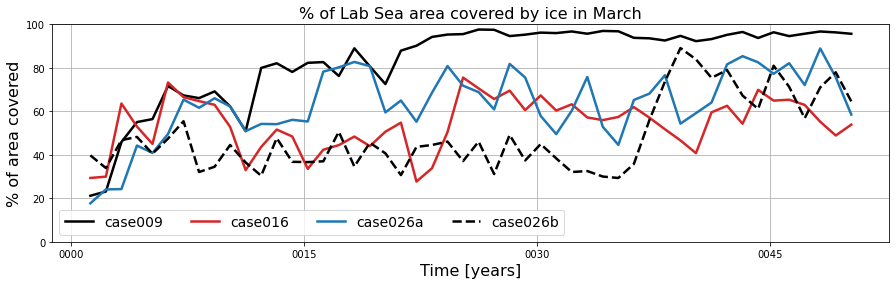

In [34]:
# load hm files 
fig = plt.figure(figsize=(15, 4))

for n in range(len(var_list)):
  print(casename[n])
  
  var = var_list_march[n]
  m = len(var)
  plt.plot(var.time[0:m-1], var[0:m-1]*100., label=label[n], 
           lw=2.5, linestyle=linestyle[n], color=color[n])

plt.title('% of Lab Sea area covered by ice in March', fontsize=16)
plt.xlabel('Time [years]', fontsize=16)
plt.ylim(0,100)
plt.ylabel("% of area covered", fontsize=16)
plt.grid()
plt.legend(fontsize=14, ncol=4);
fname='PNG/lab_sea_area_covered_by_ice_march.png'
plt.savefig(fname, dpi=150, bbox_inches='tight')